<a href="https://colab.research.google.com/github/Snir5/NLP---Disaster-Tweets-Classification/blob/main/Natural_Language_Processing_with_Disaster_Tweets_Snir_Tahasa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Participating in the Kaggle challenge by Snir Tahasa

In [2]:
# GPU Access verification
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Importing dataset from Kaggle

In [3]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd

-rw-r--r-- 1 root root 66 Jan 19 22:01 kaggle.json
/content


In [4]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 133MB/s]


In [5]:
# Get helpful functions file from github
import os 

if not os.path.exists("helpful_functions.py"):
    !wget https://raw.githubusercontent.com/Snir5/NLP---Disaster-Tweets-Classification/main/helpful_functions.py
    print("[INFO] 'helpful_functions.py' already exists, skipping download.")

In [48]:
import tensorflow as tf
from tensorflow.keras import layers

# Import series of helper functions for the notebook 
from helpful_functions import create_tensorboard_callback, load_and_prep_image, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, make_confusion_matrix, compare_baseline_to_new_results

ImportError: ignored

In [7]:
# Unzip data
unzip_data("/content/nlp-getting-started.zip")

# Dataset investigating

##Visualizing the text dataset

In [8]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [10]:
# The test data doesn't have a target (that's what we'd try to predict)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [11]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [12]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [13]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
I read about that break for hours before twitter noticed it and I though that is nothing to worry about bc twitter wasn't exploded bc of it

---

Target: 0 (not real disaster)
Text:
Join #charity 10k #run event! @DoningtonDash
11am start Sun 20 Sept 2015
Castle Donington Community First Responders
https://t.co/G1Nw99YJ8U

---

Target: 0 (not real disaster)
Text:
Do you feel like you are sinking in low self-image? Take the quiz: http://t.co/JvjALYg2n1 http://t.co/qXMWELJbc0

---

Target: 0 (not real disaster)
Text:
Diageo's CEO stresses that a board revolt at United Spirits has not impacted Indian operations http://t.co/gfs7UsulgQ

---

Target: 0 (not real disaster)
Text:
7 Christians detained in Zhejiang amid widespread anger over cross removal- over 1200 crosses removed since last yr http://t.co/8PICbkDJM0

---



# Data preprocessing

##Split data into training and validation sets

In [14]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.2, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [15]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6090, 6090, 1523, 1523)

In [16]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['Detonation fashionable mountaineering electronic watch water-resistant couples leisure tab\x89Û_ http://t.co/E61x9Y65QD http://t.co/OVLET0gDqm',
        "Men escape car engulfed in flames in Parley's Canyon crews investigating cause - http://t.co/tFan6qq2Ys http://t.co/rAkwWritPo",
        'I-77 Mile Marker 31 to 40 South Mooresville  Iredell Vehicle Accident Congestion at 8/6 1:18 PM',
        "#Greece's tax revenues collapse as debt crisis continues via @guardian #bailout http://t.co/cJvbQXw83s ^mp",
        'Be not afraid of sudden fear neither of the desolation of the wicked when it cometh. For the Lord shall be thy... http://t.co/bP597YDs2b',
        'Storm batters Auckland and Northland: A violent overnight storm has battered Auckland and Northland uprooting... http://t.co/enrPGRgtTs',
        "Benzema increasingly looks to be a casualty of Benitez's new look squad. Arsenal bound? 50-50 chance I think",
        'Acquire your postexistence straight a elevation in addition

##Converting text into numbers

In [17]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Note: in TensorFlow 2.6+, you no longer need "layers.experimental.preprocessing"
# you can use: "tf.keras.layers.TextVectorization", see https://github.com/tensorflow/tensorflow/releases/tag/v2.6.0 for more

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [18]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [19]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [20]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [21]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[240,   3, 229,   4,  13, 724,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [22]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[3691,   14, 2244, 1522, 1900, 1543, 1450, 1666, 2380, 1057, 1247,
        1012,    0,    0,    0]])>

In [23]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['minded', 'mindblowing', 'milne', 'milledgeville', 'millcityio']


##Creating an Embedding using an Embedding Layer

In [24]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

In [25]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
'you canÛªt research collective memory' The 1st Rule of writing diverse should be don't touch another group's tragedy https://t.co/PHFoEozYPS      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00123378,  0.00323629, -0.0277025 , ..., -0.01858177,
         -0.04566612,  0.04470313],
        [ 0.01222807, -0.03095179,  0.0271075 , ...,  0.0362963 ,
          0.01851131, -0.0152565 ],
        [-0.0347069 ,  0.03964214,  0.03960275, ..., -0.04710174,
         -0.03179474,  0.022281  ],
        ...,
        [ 0.00495524,  0.02930722, -0.04985551, ...,  0.03571727,
         -0.00677262,  0.01405967],
        [ 0.00325949,  0.04120575,  0.03303314, ...,  0.02435246,
          0.00536126, -0.02218335],
        [ 0.02164889,  0.04867737,  0.02949159, ...,  0.04227281,
          0.01402396,  0.00085811]]], dtype=float32)>

In [26]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.00123378,  0.00323629, -0.0277025 ,  0.00570046, -0.01650773,
       -0.03935796, -0.00188835,  0.02287897,  0.02479334, -0.03277768,
        0.04102874,  0.02642108, -0.00071342,  0.03555104,  0.02152877,
        0.01662277,  0.01932037, -0.04567856, -0.04627457, -0.04416151,
        0.02935796,  0.03297806,  0.01956587, -0.00736801, -0.00591397,
        0.03271674, -0.00199641,  0.03906878, -0.0017054 , -0.02713264,
       -0.02185251, -0.02562016,  0.00862695, -0.00473205,  0.02455579,
       -0.02622029, -0.04131745,  0.04073856, -0.00663738, -0.04066851,
        0.03835033,  0.03890531,  0.00484914,  0.04632178, -0.00471018,
       -0.01438382,  0.00029939,  0.00910326,  0.0157414 , -0.0156355 ,
       -0.00821822,  0.04332943,  0.03219527,  0.03405006,  0.03894304,
       -0.01709081, -0.03012742, -0.04314594, -0.03333032, -0.03320383,
       -0.01873484, -0.01846167,  0.00703062, -0.04250557,  0.01438809,
        0.040918

#Model 0: Baseline Model - Scikit-Learn Pipeline using the TF-IDF

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.91%


In [29]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [45]:
baseline_results = calculate_results(y_true = val_labels,
                                      y_pred = baseline_preds)
baseline_results

{'accuracy': 0.799080761654629,
 'precision': 0.8146358812834972,
 'recall': 0.799080761654629,
 'f1': 0.7920155324845473}

#Model 1: A simple dense model

In [32]:
# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [33]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
text_vectorization = text_vectorizer(inputs) # turn the input text into numbers
embedding_layer = embedding(text_vectorization) # create an embedding of the numerized numbers
pooling_layer = layers.GlobalAveragePooling1D()(embedding_layer) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(pooling_layer) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [34]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [35]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [36]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20230119-221325
Epoch 1/5
191/191 [==============================] - 4s 15ms/step - loss: 0.6203 - accuracy: 0.6829 - val_loss: 0.5493 - val_accuracy: 0.7479
Epoch 2/5
191/191 [==============================] - 3s 14ms/step - loss: 0.4544 - accuracy: 0.8130 - val_loss: 0.4765 - val_accuracy: 0.7840
Epoch 3/5
191/191 [==============================] - 3s 14ms/step - loss: 0.3537 - accuracy: 0.8588 - val_loss: 0.4639 - val_accuracy: 0.7938
Epoch 4/5
191/191 [==============================] - 3s 17ms/step - loss: 0.2870 - accuracy: 0.8895 - val_loss: 0.4649 - val_accuracy: 0.7886
Epoch 5/5
191/191 [==============================] - 3s 14ms/step - loss: 0.2380 - accuracy: 0.9115 - val_loss: 0.4761 - val_accuracy: 0.7912


In [37]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

48/48 [==============================] - 0s 6ms/step - loss: 0.4761 - accuracy: 0.7912


[0.47612395882606506, 0.7912015914916992]

In [39]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:5] # only print out the first 10 prediction probabilities

48/48 [==============================] - 0s 4ms/step


array([[0.4289186 ],
       [0.8768747 ],
       [0.99696463],
       [0.14271997],
       [0.10521299]], dtype=float32)

In [41]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

In [42]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 0.7912015758371634,
 'precision': 0.7925821381563427,
 'recall': 0.7912015758371634,
 'f1': 0.788610841152863}

In [46]:
# Compare our first deep model to our baseline model
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

##Visualizing learned embeddings

In [50]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [51]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [52]:
# Get the weight matrix of embedding layer 
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

(10000, 128)


#Model 2: LSTM

In [53]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [54]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [55]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [56]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230119-222127
Epoch 1/5
191/191 [==============================] - 10s 35ms/step - loss: 0.5148 - accuracy: 0.7417 - val_loss: 0.4562 - val_accuracy: 0.7919
Epoch 2/5
191/191 [==============================] - 7s 35ms/step - loss: 0.3079 - accuracy: 0.8759 - val_loss: 0.4919 - val_accuracy: 0.7886
Epoch 3/5
191/191 [==============================] - 7s 35ms/step - loss: 0.2061 - accuracy: 0.9259 - val_loss: 0.5790 - val_accuracy: 0.7781
Epoch 4/5
191/191 [==============================] - 6s 32ms/step - loss: 0.1370 - accuracy: 0.9522 - val_loss: 0.8057 - val_accuracy: 0.7387
Epoch 5/5
191/191 [==============================] - 8s 39ms/step - loss: 0.0988 - accuracy: 0.9622 - val_loss: 0.8749 - val_accuracy: 0.7761


In [57]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

48/48 [==============================] - 1s 5ms/step


((1523, 1), array([[0.00745296],
        [0.97041905],
        [0.99973786],
        [0.02123579],
        [0.00179881],
        [0.99978286],
        [0.98665017],
        [0.99988353],
        [0.99937797],
        [0.1028028 ]], dtype=float32))

In [58]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [59]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 0.7760998030203545,
 'precision': 0.7799128466109629,
 'recall': 0.7760998030203545,
 'f1': 0.7717135603537261}

NameError: ignored

#Model 3: GRU

In [61]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [62]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [63]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [64]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20230119-222240
Epoch 1/5
191/191 [==============================] - 9s 33ms/step - loss: 0.5373 - accuracy: 0.7184 - val_loss: 0.4595 - val_accuracy: 0.7859
Epoch 2/5
191/191 [==============================] - 5s 27ms/step - loss: 0.3152 - accuracy: 0.8695 - val_loss: 0.4825 - val_accuracy: 0.7905
Epoch 3/5
191/191 [==============================] - 5s 26ms/step - loss: 0.2081 - accuracy: 0.9228 - val_loss: 0.5681 - val_accuracy: 0.7807
Epoch 4/5
191/191 [==============================] - 6s 31ms/step - loss: 0.1440 - accuracy: 0.9498 - val_loss: 0.6821 - val_accuracy: 0.7538
Epoch 5/5
191/191 [==============================] - 5s 24ms/step - loss: 0.1101 - accuracy: 0.9631 - val_loss: 0.6824 - val_accuracy: 0.7807


In [65]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

48/48 [==============================] - 1s 4ms/step


((1523, 1), array([[0.2419385 ],
        [0.9949791 ],
        [0.9995149 ],
        [0.03639984],
        [0.00487015],
        [0.9984538 ],
        [0.72259647],
        [0.9995729 ],
        [0.9960137 ],
        [0.08195259]], dtype=float32))

In [66]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [100]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 0.7806959947472094,
 'precision': 0.7826848815030036,
 'recall': 0.7806959947472094,
 'f1': 0.7774148810995897}

#Model 4: Bidirectonal RNN model

In [67]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [68]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [69]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [70]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20230119-222350
Epoch 1/5
191/191 [==============================] - 15s 56ms/step - loss: 0.5142 - accuracy: 0.7422 - val_loss: 0.4612 - val_accuracy: 0.7846
Epoch 2/5
191/191 [==============================] - 8s 40ms/step - loss: 0.3005 - accuracy: 0.8772 - val_loss: 0.4959 - val_accuracy: 0.7905
Epoch 3/5
191/191 [==============================] - 8s 40ms/step - loss: 0.1929 - accuracy: 0.9302 - val_loss: 0.5944 - val_accuracy: 0.7715
Epoch 4/5
191/191 [==============================] - 8s 40ms/step - loss: 0.1265 - accuracy: 0.9568 - val_loss: 0.6148 - val_accuracy: 0.7597
Epoch 5/5
191/191 [==============================] - 8s 41ms/step - loss: 0.0889 - accuracy: 0.9698 - val_loss: 0.8083 - val_accuracy: 0.7741


In [71]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

48/48 [==============================] - 2s 7ms/step


array([[0.00641189],
       [0.855687  ],
       [0.9992394 ],
       [0.05116506],
       [0.00210377],
       [0.99617773],
       [0.8650405 ],
       [0.9996206 ],
       [0.99866974],
       [0.13761592]], dtype=float32)

In [73]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [74]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 0.7741300065659882,
 'precision': 0.7771575469035554,
 'recall': 0.7741300065659882,
 'f1': 0.7700364230549597}

#Model 5: Conv1D - Convolutional Neural Networks for Text

In [72]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D() 
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [75]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.05392782, -0.06433333,  0.02464818, ...,  0.02305483,
          -0.00435908, -0.0669346 ],
         [-0.0618613 ,  0.08901561, -0.01599718, ...,  0.00103266,
          -0.04327994,  0.07912869],
         [-0.05018414, -0.00323672, -0.02844086, ..., -0.02380141,
           0.01837384,  0.03180464],
         ...,
         [ 0.00832682,  0.0098035 , -0.03011985, ..., -0.04111385,
          -0.00624722,  0.01474805],
         [ 0.00832682,  0.0098035 , -0.03011985, ..., -0.04111385,
          -0.00624722,  0.01474805],
         [ 0.00832682,  0.0098035 , -0.03011985, ..., -0.04111385,
          -0.00624722,  0.01474805]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[7.41508454e-02, 0.00000000e+00, 0.00000000e+00, 5.16876094e-02,
          0.00000000e+00, 7.07956478e-02, 1.17013650e-02, 3.30818407e-02,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          3.

In [76]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [77]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230119-222557
Epoch 1/5
191/191 [==============================] - 6s 23ms/step - loss: 0.5767 - accuracy: 0.7053 - val_loss: 0.4799 - val_accuracy: 0.7840
Epoch 2/5
191/191 [==============================] - 4s 20ms/step - loss: 0.3441 - accuracy: 0.8565 - val_loss: 0.4734 - val_accuracy: 0.7912
Epoch 3/5
191/191 [==============================] - 3s 17ms/step - loss: 0.2006 - accuracy: 0.9310 - val_loss: 0.5413 - val_accuracy: 0.7853
Epoch 4/5
191/191 [==============================] - 4s 19ms/step - loss: 0.1235 - accuracy: 0.9609 - val_loss: 0.6140 - val_accuracy: 0.7682
Epoch 5/5
191/191 [==============================] - 3s 18ms/step - loss: 0.0876 - accuracy: 0.9716 - val_loss: 0.6710 - val_accuracy: 0.7794


In [78]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

48/48 [==============================] - 1s 5ms/step


array([[0.65679574],
       [0.98327094],
       [0.9990368 ],
       [0.01306556],
       [0.01060766],
       [0.9977144 ],
       [0.9891901 ],
       [0.99803877],
       [0.99875355],
       [0.09627719]], dtype=float32)

In [79]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [80]:
# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 0.7793827971109653,
 'precision': 0.7792295252375863,
 'recall': 0.7793827971109653,
 'f1': 0.7775113843401158}

#Model 6: TensorFlow Hub Pretrained Sentence Encoder

In [81]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [82]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

In [83]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [84]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [85]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230119-222737
Epoch 1/5
191/191 [==============================] - 8s 22ms/step - loss: 0.5084 - accuracy: 0.7847 - val_loss: 0.4499 - val_accuracy: 0.7978
Epoch 2/5
191/191 [==============================] - 3s 16ms/step - loss: 0.4136 - accuracy: 0.8151 - val_loss: 0.4405 - val_accuracy: 0.7971
Epoch 3/5
191/191 [==============================] - 4s 20ms/step - loss: 0.3978 - accuracy: 0.8215 - val_loss: 0.4424 - val_accuracy: 0.8017
Epoch 4/5
191/191 [==============================] - 3s 14ms/step - loss: 0.3884 - accuracy: 0.8292 - val_loss: 0.4386 - val_accuracy: 0.8050
Epoch 5/5
191/191 [==============================] - 3s 14ms/step - loss: 0.3823 - accuracy: 0.8282 - val_loss: 0.4385 - val_accuracy: 0.8070


In [86]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

48/48 [==============================] - 1s 16ms/step


array([[0.2139807 ],
       [0.82575995],
       [0.9846674 ],
       [0.16841167],
       [0.7745637 ],
       [0.7665995 ],
       [0.9826167 ],
       [0.97755855],
       [0.91985244],
       [0.10260993]], dtype=float32)

In [87]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [88]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results


{'accuracy': 0.8069599474720945,
 'precision': 0.8067113855704031,
 'recall': 0.8069599474720945,
 'f1': 0.8058715093594799}

# Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

In [89]:
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [90]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6090
Length of 10% training examples: 609


In [91]:
# Check the number of targets in our subset of data 
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

0    326
1    283
dtype: int64

In [92]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [93]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20230119-222902
Epoch 1/5
20/20 [==============================] - 5s 80ms/step - loss: 0.6766 - accuracy: 0.6552 - val_loss: 0.6532 - val_accuracy: 0.7459
Epoch 2/5
20/20 [==============================] - 1s 55ms/step - loss: 0.6201 - accuracy: 0.7947 - val_loss: 0.6025 - val_accuracy: 0.7669
Epoch 3/5
20/20 [==============================] - 2s 94ms/step - loss: 0.5580 - accuracy: 0.7915 - val_loss: 0.5547 - val_accuracy: 0.7682
Epoch 4/5
20/20 [==============================] - 1s 54ms/step - loss: 0.5041 - accuracy: 0.8046 - val_loss: 0.5206 - val_accuracy: 0.7682
Epoch 5/5
20/20 [==============================] - 1s 47ms/step - loss: 0.4638 - accuracy: 0.8046 - val_loss: 0.5014 - val_accuracy: 0.7689


In [94]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

48/48 [==============================] - 1s 10ms/step


array([[0.40308732],
       [0.7443358 ],
       [0.8429857 ],
       [0.33702904],
       [0.67573583],
       [0.83989686],
       [0.8251908 ],
       [0.8536417 ],
       [0.70620656],
       [0.2585744 ]], dtype=float32)

In [95]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [96]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 0.7688772160210111,
 'precision': 0.7689572266106439,
 'recall': 0.7688772160210111,
 'f1': 0.7689158875265948}

#Comparing the performance of each of our models

In [101]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,0.799081,0.814636,0.799081,0.792016
simple_dense,0.791202,0.792582,0.791202,0.788611
lstm,0.776100,0.779913,0.776100,0.771714
gru,0.780696,0.782685,0.780696,0.777415
bidirectional,0.774130,0.777158,0.774130,0.770036
conv1d,0.779383,0.779230,0.779383,0.777511
tf_hub_sentence_encoder,0.806960,0.806711,0.806960,0.805872
tf_hub_10_percent_data,0.768877,0.768957,0.768877,0.768916


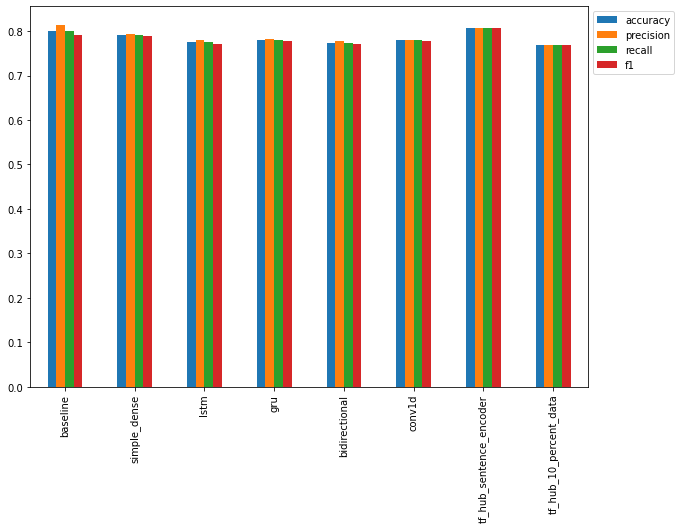

In [102]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

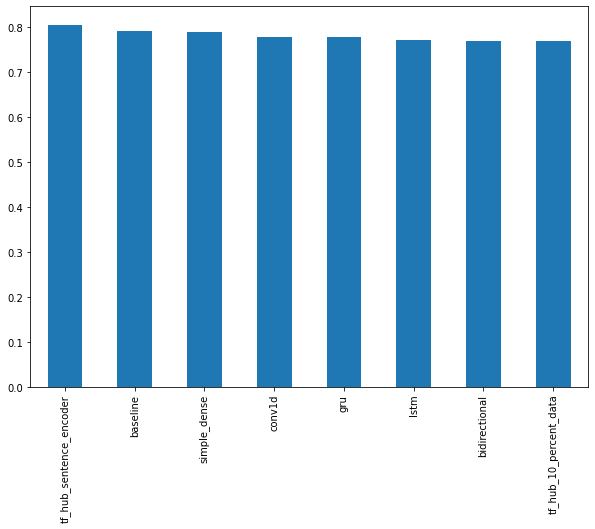

In [103]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

#Combining our models (model ensembling/stacking)

In [105]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [106]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 0.7957977675640184,
 'precision': 0.7954583800255974,
 'recall': 0.7957977675640184,
 'f1': 0.7945642478065194}

In [108]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [109]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.799081,0.814636,0.799081,0.792016
simple_dense,0.791202,0.792582,0.791202,0.788611
lstm,0.776100,0.779913,0.776100,0.771714
gru,0.780696,0.782685,0.780696,0.777415
bidirectional,0.774130,0.777158,0.774130,0.770036
conv1d,0.779383,0.779230,0.779383,0.777511
tf_hub_sentence_encoder,0.806960,0.806711,0.806960,0.805872
tf_hub_10_percent_data,0.768877,0.768957,0.768877,0.768916
ensemble_results,0.795798,0.795458,0.795798,0.794564


#Saving and loading a trained model

In [ ]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [ ]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5", 
                                            custom_objects={"KerasLayer": hub.KerasLayer})

#Finding the most wrong examples

In [110]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.213981
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.825760
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.984667
3,@camilacabello97 Internally and externally scr...,1,0.0,0.168412
4,Radiation emergency #preparedness starts with ...,1,1.0,0.774564


In [111]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
881,@adorableappple No reported flooding po in the...,0,1.0,0.975280
1307,We should all have a fire safety plan. RT @Mat...,0,1.0,0.956704
846,Mourning notices for stabbing arson victims st...,0,1.0,0.945863
1502,Two Jewish Terrorists Charged In Historic-Chur...,0,1.0,0.937804
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.928019
759,FedEx will no longer transport bioterror patho...,0,1.0,0.919399
814,the MOFO in DC will leave our military unarmed...,0,1.0,0.900807
769,Weapons stolen from National Guard Armory in N...,0,1.0,0.900257
813,Aug. 5: The Fort Calhoun Nuclear Station is at...,0,1.0,0.898012
1467,Bloor/Ossington arsonist also burned a mattres...,0,1.0,0.894712


In [113]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:5].itertuples(): # loop through the top 5 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9752795696258545
Text:
@adorableappple No reported flooding po in the area. Ten-4. #mmda

----

Target: 0, Pred: 1, Prob: 0.9567040801048279
Text:
We should all have a fire safety plan. RT @Matt_Kroschel: MOCK WILDFIRE near #Vail as agencies prepare for the worst. http://t.co/SWwyLRk0fv

----

Target: 0, Pred: 1, Prob: 0.9458633065223694
Text:
Mourning notices for stabbing arson victims stir Û÷politics of griefÛª in Israel: Posters for Shira Banki and A... http://t.co/3GZ5zQQTHe

----

Target: 0, Pred: 1, Prob: 0.9378035664558411
Text:
Two Jewish Terrorists Charged In Historic-Church Arson | The Ugly Truth http://t.co/iEksNFSbY7 http://t.co/VWCf3slkrW

----

Target: 0, Pred: 1, Prob: 0.9280190467834473
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----



In [114]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-5:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.040121376514434814
Text:
'I did another one I did another one. You still ain't done shit about the other one.' Nigga body bagging Meek.

----

Target: 1, Pred: 0, Prob: 0.03682408854365349
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.03672895208001137
Text:
Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvNJ4sAP

----

Target: 1, Pred: 0, Prob: 0.03585819527506828
Text:
Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube

----

Target: 1, Pred: 0, Prob: 0.03553687036037445
Text:
destroy the free fandom honestly

----



#Making predictions on the test dataset

In [115]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 5)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 42ms/step
Pred: 1, Prob: 0.6119117140769958
Text:
Now Trending in Nigeria: Police charge traditional ruler others with informantÛªs  murder http://t.co/DQhpm4A5qY

----

1/1 [==============================] - 0s 45ms/step
Pred: 1, Prob: 0.8144282102584839
Text:
http://t.co/OK9EBHurfl If your neighborhood school falls into a sinkhole State Sen. Steve Yarbrough may be close by...

----

1/1 [==============================] - 0s 56ms/step
Pred: 0, Prob: 0.1349387913942337
Text:
I don't think it was. It was very realistic. Scully finally had him home and sfe and he wanted to go out into the danger. @HipsBeforeHands

----

1/1 [==============================] - 0s 80ms/step
Pred: 1, Prob: 0.9201537370681763
Text:
@VICE no sympathyONLF is a terrorist group affiliated with AL shabab This is war! Go report on  war crimes committed by Western powers!

----

1/1 [==============================] - 0s 49ms/step
Pred: 0, Prob: 0.15827038884162903
Text:
@Sh

# Predicting on Tweets from the wild

In [119]:
# Turn Tweet into string
james_tweet = "Life like an ensemble: take the best choices from others and make your own"

In [120]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [121]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=james_tweet)

1/1 [==============================] - 0s 39ms/step
Pred: 0.0 (not real disaster) Prob: 0.06509328633546829
Text:
Life like an ensemble: take the best choices from others and make your own


In [122]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [123]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_1)

1/1 [==============================] - 0s 47ms/step
Pred: 1.0 (real disaster) Prob: 0.9596869945526123
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [124]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_2)

1/1 [==============================] - 0s 53ms/step
Pred: 1.0 (real disaster) Prob: 0.9689095616340637
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


#The speed/score tradeoff

In [126]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  
  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [127]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

48/48 [==============================] - 0s 10ms/step


(0.5882569229997898, 0.00038624880039382127)

In [128]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.03180422899959012, 2.0882619172416363e-05)

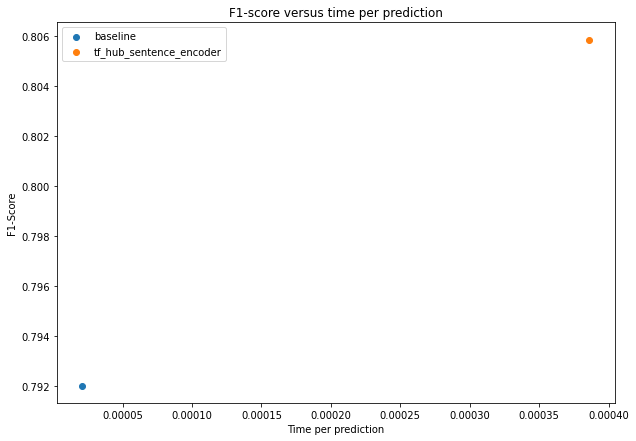

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");